## __SE-PINN__

This is the implementation of a physics-informed neural network (PINN) in PyTorch to solve the Schrodinger equation of quantum mechanics.

__Integration of Physical Constraints__

Four physical constraints are integrated into the model: normality, orthogonality, symmetry, and the Schrodinger equation itself.

These physical constraints are integrated via two methods: (1) inclusion in the objective function (used for normality, orthogonality, and the Schrodinger equation) and (2) exact conservation via the architecture (used for symmetry).

__(1) Normality__

__Physics__: In the Copenhagen interpretation of quantum mechanics, the square of the modulus of the wavefunction is a probability of the observation of a state.

__Mathematics__: Because of the probabilistic interpretation of the wavefunction, the sum of the squares of the modulus is equal to 1.

__Computing__: To integrate normality, a component is included in the objective function.

__Code__: `NL_loss = (torch.sum(wf**2) - 1/self.dx)**2`

__(2) Orthogonality__

__Physics__: Because measurements of physical quantities are real numbers (rather than complex numbers), physical operators are Hermitian.

__Mathematics__: The set of all eigenvectors of any Hermitian operator is a basis of Hilbert space, so they are all orthogonal to each other.

__Computing__: To integrate orthogonality, a component is included in the objective function.

__Code__: `Orth_loss = (torch.sum(wf*self.basis_sum)*self.dx)**2`

__(3) Symmetry__

__Physics__: For particular quantum-mechanical potentials that are symmetric, the energy eigenvectors are also symmetric.

__Mathematics__: Due to the mathematical fact that every function can be expressed as the sum of an even function and an odd function, its even part and its odd part can be separated and selected.

__Computing__: To integrate symmetry, a custom architectural layer, a hub layer, is used at the end of the model.

__Code__: `
N = ((self.even * (1/2) * torch.mm(H_plus, self.weights.t()))
           + (self.odd * (1/2) * torch.mm(H_minus, self.weights.t())))
           `

__(4) Information from the SE Itself__

Last, the model is steered toward physical solutions by comparings its predictions to the Schrodinger equation itself and including the distance in the objective function.

__Code__: `SE_loss = torch.sum((-0.5*dd + self.V*wf - energy*wf)**2)/self.N`

### __(1/5) Preparation__

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
# !pip install latex
# !pip install git+https://github.com/garrettj403/SciencePlots # Temporary
# import scienceplots # Temporary
# plt.style.use(['science','grid'])
from scipy.linalg import eigh_tridiagonal, eigvalsh_tridiagonal
import torch
import torch.nn as nn
import torch.nn.functional as F

!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia

# Optional Hardware Acceleration
if torch.cuda.is_available(): # Use T4 GPU on Google Colab
    torch.cuda.init()
    torch.cuda.is_initialized()
    torch.set_default_tensor_type('torch.cuda.FloatTensor') # torch.set_default_dtype() and torch.set_default_device()
    device = "cuda" # torch.device("cuda")
else:
    device = "cpu"

# !pip install torch_xla[tpu]~=2.1.0 -f https://storage.googleapis.com/libtpu-releases/index.html
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

torch.manual_seed(0) # Specify the random seed for reproducibility.

# This is a shortcut to plot pytorch tensors (they need to be in numpy form for matplotlib).
def to_plot(x): return x.detach().cpu().numpy()

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link



/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


### __(2/5) Definition of PINN__

In [ ]:
class PINN(nn.Module):
    """
    Physics-informed neural network (PINN) to solve the Schrodinger equation.

    Attributes
    ----------
    x0 : float
        the spatial position of the leftmost point of the quantum-mechanical potential
    xN : float
        the spatial position of the rightmost point of the quantum-mechanical potential
    dx : float
        the uniform spatial Euclidean distance between adjacent points
    N : int
        the count of points
    activation : builtin_function_or_method
        the activation function
    sym : int
        whether to enforce even symmetry (1) or odd symmetry (-1) or not to enforce symmetry (0)

    Methods
    -------
    swap_symmetry
        Swap the symmetry of the prediction of the model between even symmetry and odd symmetry.

    forward(x)
        Forward pass.
    """

    def  __init__(self, grid_params, activation, sym = 0):
        super(PINN, self).__init__()

        self.x0, self.xN, self.dx, self.N = grid_params
        self.activation = activation
        self.sym = sym

        # Architecture of the Model

        self.energy_node = nn.Linear(1,1)
        self.fc1_bypass = nn.Linear(1,50)
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)

        # Automatic detection of whether to enforce even symmetry or odd symmetry via a hub layer
        if sym == 1:
            self.output = HubLayer(50, 1, 1, 0) # Even Symmetry
        elif sym == -1:
            self.output = HubLayer(50, 1, 0, 1) # Odd Symmetry
        else:
            self.output = nn.Linear(50,1)

    def swap_symmetry(self):
        if self.sym == 0:
            print("Tried to swap symmetry although none is enforced.")
            return
        self.output.flip_sym()

    def forward(self, x):
        # lambda layer for energy
        energy = self.energy_node(torch.ones_like(x))

        N = torch.cat((x,energy),1)
        N = self.activation(self.fc1(N))
        N = self.activation(self.fc2(N))
        N = self.output(N) # where symmetrization occurs if enforced

        wf = N

        return wf, energy

class HubLayer(nn.Module):
    """
    Hub layer, which is used to constrain the prediction of the model to respect even symmetry
    (symmetry about f(x) = 0) or odd symmetry (symmetry about f(x) = x). The mathematical basis is
    presented at https://arxiv.org/pdf/1904.08991.pdf. The constructor is adapted from
    https://auro-227.medium.com/writing-a-custom-layer-in-pytorch-14ab6ac94b77.

    Attributes
    ----------
    size_in : int
        the length of the input of the layer
    size_out : int
        the length of the output of the layer
    weights : torch.nn.parameter.Parameter
        the weights of the layer
    bias : torch.nn.parameter.Parameter
        the bias of the layer
    even : int
        1 to enforce even symmetry
    odd : int
        -1 to enforce odd symmetry

    Methods
    -------
    flip_sym
        Swap the symmetry between even symmetry and odd symmetry.

    forward(x)
        Forward pass.
    """

    def __init__(self, size_in, size_out, even, odd):
        super().__init__()

        self.size_in, self.size_out = size_in, size_out

        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        self.even = even
        self.odd = odd

        # Initialization of Weights
        nn.init.kaiming_uniform_(self.weights, a=np.sqrt(5))

        # Initialization of Biases
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

    def flip_sym(self):
        self.even = 1 - self.even
        self.odd = 1 - self.odd
        return

    def forward(self, x):
        h_plus = x # x(t)
        h_minus = torch.flip(x, [0]) # x(-t)
        H_plus = h_plus + h_minus
        H_minus = h_plus - h_minus

        N = ((self.even * (1/2) * torch.mm(H_plus, self.weights.t()))
           + (self.odd * (1/2) * torch.mm(H_minus, self.weights.t())))

        return N

### __(3/5) Definition of Wrapped PINN__

In [ ]:
class WrappedPINN():
    def __init__(self, grid_params, activation, potential, sym):
        self.x0, self.xN, self.dx, self.N = grid_params

        self.x = torch.linspace(self.x0, self.xN, self.N - 1).view(-1, 1)
        self.V = potential

        self.model = PINN(grid_params, activation, sym)
        self.model.to(device)

        # Persistent information about the predicted basis.
        self.basis = []
        self.basis_sum = torch.zeros_like(self.x)

        # Current output of the model.
        self.cur_loss = 0
        self.cur_energy = 0
        self.cur_wf = 0

        # Lists for visualization of the history of the model.
        self.losses = []
        self.energies = []
        self.wfs = []

    def init_optimizer(self, optim, lr = 1e-2):
        if optim == "LBFGS":
            self.opt = torch.optim.LBFGS(self.model.parameters(), lr=lr)
        elif optim == "Adam":
            self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        else:
            print("Invalid Optimizer")
        self.opt_name = optim

    def change_lr(self,lr):
        """
        On-the-fly (runtime) control of the learning rate.
        """
        self.opt.param_groups[0]['lr'] = lr

    def swap_symmetry(self):
        """
        On-the-fly (runtime) control of the enforced symmetry.
        """
        self.model.swap_symmetry()

    def add_to_basis(self, base=None):
        if base is None:
            base = self.cur_wf.clone().detach()
        self.basis.append(base)
        self.basis_sum += base

    def closure(self):
        self.opt.zero_grad()
        l = self.loss(self.x)
        l.backward()
        return l

    def loss(self, x):
        self.x.requires_grad = True
        wf, energy = self.model(self.x)

        d = torch.autograd.grad(wf.sum(), x, create_graph=True)[0]
        dd = torch.autograd.grad(d.sum(), x, create_graph=True)[0] # 2nd derivative
        SE_loss = torch.sum((-0.5 * dd + self.V * wf - energy * wf) ** 2) / self.N

        NL_loss = (torch.sum(wf ** 2) - 1 / self.dx) ** 2

        Orth_loss = (torch.sum(wf * self.basis_sum) * self.dx) ** 2

        loss = SE_loss + NL_loss + Orth_loss + 0.5 * (wf[0] ** 2 + wf[-1] ** 2) # boundary loss

        self.cur_wf, self.cur_energy, self.cur_loss = wf, energy[0].item(), loss.item()

        return loss

    def train(self, epochs):
        for i in range(epochs):
            if self.opt_name == "LBFGS":
                loss = self.opt.step(self.closure)
                if loss.item() == torch.nan:
                    print("NAN loss")
                    break

            if self.opt_name == "Adam":
                self.opt.zero_grad()
                loss = self.loss(self.x)
                loss.backward()
                self.opt.step()

            self.wfs.append(self.cur_wf)
            self.energies.append(self.cur_energy)
            self.losses.append(self.cur_loss)

    def plot_loss(self):
        plt.plot(self.losses)
        plt.yscale('log')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title('Loss during Training')
        plt.show()

    def plot_energy(self):
        plt.plot(self.energies)
        plt.title('Predicted Energy Eigenvalue during Training')
        plt.xlabel("Epoch")
        plt.ylabel("Energy Eigenvalue")
        plt.show()

    def plot_wf(self, idx=None, ref=None):
        fig = plt.figure(figsize=(6,4))
        if idx is None:
            psi = self.cur_wf
        else:
            psi = self.wfs[idx]
        plt.plot(to_plot(self.x), to_plot(psi), 'r-', linewidth=2, label='Prediction')
        plt.plot(to_plot(self.x), -to_plot(psi), 'b-', linewidth=2, label='- Prediction')
        if ref is not None:
            plt.plot(to_plot(self.x), ref, 'k--', linewidth=2, label='Ground Truth')

        plt.xlabel("x")
        plt.ylabel("Energy Eigenvector")
        plt.title(f'Predicted Energy Eigenvector (E = {self.cur_energy:.2f}, norm = {torch.sum(psi ** 2) * self.dx:.2f})')
        plt.legend()
        plt.show()

    def create_gif(self, name, ref_wf=None, ref_ener=None, epoch_range=None):
        if epoch_range is None:
            epoch_range = 0, len(self.losses)
        num_frames = epoch_range[1] - epoch_range[0]

        fig, axes = plt.subplots(1, 2, figsize=(12,4))
        def animate(i):
            idx = epoch_range[0] + i
            ax = axes[0]
            ax.clear()
            ax.plot(to_plot(self.x),  to_plot(self.wfs[idx]), 'r-', linewidth=2, label='Prediction')
            ax.plot(to_plot(self.x), -to_plot(self.wfs[idx]), 'b-', linewidth=2, label='- Prediction')
            if ref_wf is not None:
                ax.plot(to_plot(self.x), ref_wf,  'k--', linewidth=2, label='Ground Truth')
            ax.set_title(f'Epoch {i}: Energy = {self.energies[idx]:.2f}')
            ax.legend()
            ax.set_ylim([-1.5,1.5])

            ax = axes[1]
            ax.clear()
            ax.plot(np.arange(epoch_range[0],idx),self.energies[epoch_range[0]:idx])
            ax.set_xlim([epoch_range[0],epoch_range[1]])
            if ref_ener is not None:
                ax.axhline(ref_ener, color='k', linestyle="--", label="Ground Truth")
            ax.set_title('Energy')
            ax.legend()

        ani = FuncAnimation(fig, animate, frames=num_frames - 1, interval=500)
        ani.save(name+".gif", dpi=100, writer=PillowWriter(fps=50))
        plt.close()

### __(4/5) Definition of Physical System__

In [ ]:
# Definition of Physical System (Simple Harmonic Oscillator)

N = 500
x0, xN = -5.0, 5.0
dx = (xN - x0) / N
grid_params = x0, xN, dx, N

x = torch.linspace(x0, xN, N+1).view(-1, 1)
k = 100
V = 0.5 * k * x ** 2

In [ ]:
# Solve via the numerical method.

diagonal = 1 / dx**2 + V[1:-1].detach().cpu().numpy()[:,0]
edge = -0.5 / dx**2 * np.ones(diagonal.shape[0] - 1)
energies, eigenvectors = eigh_tridiagonal(diagonal, edge)

# Normalization of eigenvectors.
norms = dx * np.sum(eigenvectors ** 2, axis=0)
eigenvectors /= np.sqrt(norms)

gnd_state = eigenvectors.T[0]
gnd_energy = energies[0]

x = torch.linspace(x0, xN, N - 1).view(-1, 1)
V = 0.5 * k * x ** 2

### __(5/5) Application of Wrapped PINN__

In [ ]:
# Initialization of Wrapped PINN.
wrapped_pinn = WrappedPINN(grid_params, torch.tanh, V, sym=1)
wrapped_pinn.init_optimizer("LBFGS", lr=1e-3)

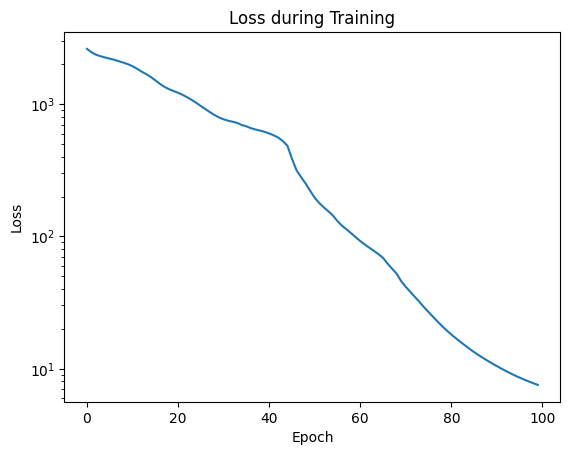

In [ ]:
# Exploration of the effect of training on the loss.
wrapped_pinn.train(100)
wrapped_pinn.plot_loss()

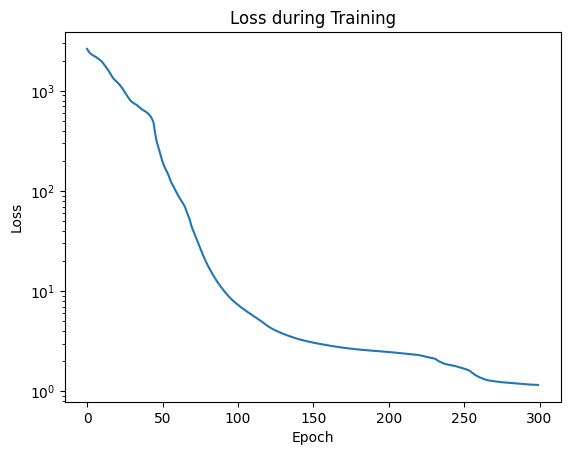

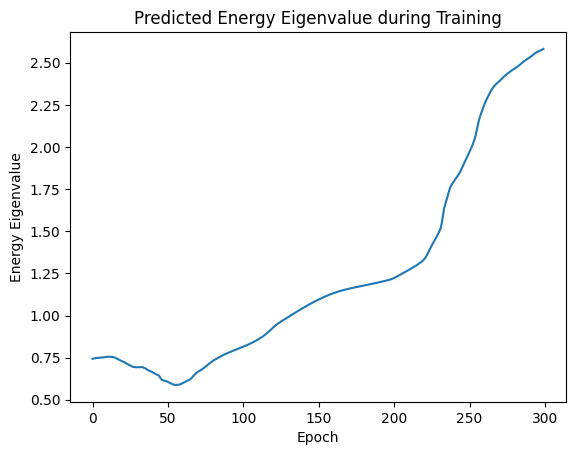

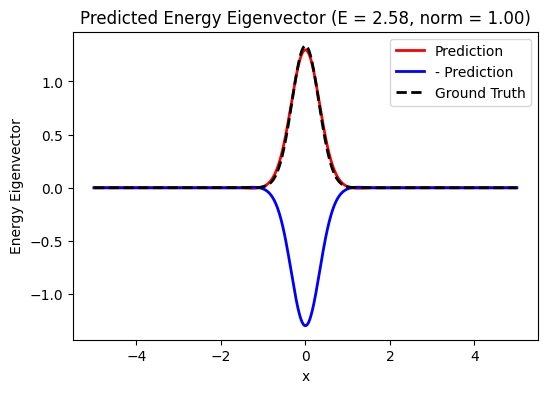

In [ ]:
# Continuation of training.
wrapped_pinn.train(200)

# Visualization.
wrapped_pinn.plot_loss()
wrapped_pinn.plot_energy()
wrapped_pinn.plot_wf(ref=gnd_state)

In [ ]:
# Continuation of training.
wrapped_pinn.train(300)

# Visualization via animation.
wrapped_pinn.create_gif("animation", ref_ener=energies[0], ref_wf=gnd_state)